In [1]:
import pandas as pd
import numpy as np
dirty_data_priora = pd.read_csv('C:\\Users\\Lo_Sci\\Desktop\\Py\\Prio\\Priora_List1.csv')

# подготавливаем цифровые данные
priora_only_input = dirty_data_priora[['дата', 'часы в пути', 'минуты в пути', 'пробег', 'средний расход', 
                                       'температура', 'маршрут', 'топливо', 'откуда', 'до куда']]
priora_num = priora_only_input.rename(columns={'часы в пути': 'hours', 'маршрут': 'km', 'минуты в пути':'minutes'})
priora_num['temperature'] = pd.to_numeric(priora_num['температура'].str.replace(',','.'), errors='coerce')
priora_num['path'] = pd.to_numeric(priora_num['km'].str.replace(',','.'), errors='coerce')
priora_num['hrs'] = priora_num.hours + priora_num.minutes/60
priora_num['fuel'] = pd.to_numeric(priora_num['топливо'].str.replace(',','.'), errors='coerce')
priora_num['time_h'] = np.diff(priora_num.hrs, prepend=0)
priora_num['benz'] = np.diff(priora_num.fuel, prepend=0)
priora_num['distance'] = np.diff(priora_num.path, prepend=0)
priora_num['av_speed'] = priora_num.distance / priora_num.time_h
priora_num['rashod'] = 100 * priora_num.benz / priora_num.distance

priora_num.drop(columns=['откуда', 'до куда']).head()

# отфильтровываем неразумные данные и исключаем нечисловые (вспомогательные информационные) колонки
priora_detailsfree = priora_num[['temperature', 'distance', 'time_h', 'benz', 'av_speed', 'rashod']] \
                    .query('distance > 3 & time_h > 0 & rashod < 50')
priora_detailsfree.head()

,temperature,distance,time_h,benz,av_speed,rashod
2,2.0,32.8,0.633333,2.8,51.789474,8.536585
4,1.0,35.6,0.666667,2.3,53.400000,6.460674
5,24.0,366.2,16.066667,37.2,22.792531,10.158383
6,24.0,5.3,0.083333,0.4,63.600000,7.547170
7,24.0,66.2,1.283333,4.8,51.584416,7.250755


In [2]:
# высчитываем глобальные величины по всей базе
global_sr_ras = 100 * priora_detailsfree.benz.sum() / priora_detailsfree.distance.sum()
global_sr_skor = priora_detailsfree.distance.sum() / priora_detailsfree.time_h.sum()
global_sr_temp = priora_detailsfree.temperature.mean()
print(
        'средняя скорось за все время эксплуатации = ', round(global_sr_skor, 2),
        'км/ч, при среднем расходе', round(global_sr_ras, 2), 'л/100км. ',
        'cредняя температура = ', round(global_sr_temp, 1), u'\N{DEGREE SIGN}', 'C'
     )

средняя скорось за все время эксплуатации =  24.76 км/ч, при среднем расходе 9.82 л/100км.  cредняя температура =  11.3 ° C


In [3]:
# удаляем наны
priora_detailsfree['BadPoint'] = priora_detailsfree['temperature'].isnull()
priora_detailsfree2 = priora_detailsfree.dropna().drop('BadPoint', axis=1)

In [4]:
# датасет для нейросети
array = priora_detailsfree2[['av_speed', 'temperature', 'rashod']]
X = array.drop(columns=['rashod'])
Y = array['rashod']
X.to_csv('Priora_X_train', header=False, index=False)
Y.to_csv('Priora_Y_train', header=False, index=False)

In [5]:
# данные для предсказания нейросети
Priora_pred_data2 = pd.DataFrame(columns=['vel', 'temperature'])
for T in range(-30, 35, 5):
    temper = T
    for i in range(0, 45):
        v = 3+i*2
        temp = pd.DataFrame.from_dict({'vel': [v], 'temperature': [T]})
        Priora_pred_data2 = Priora_pred_data2.append(temp, ignore_index=True)
Priora_pred_data2.to_csv('Priora_X_predict2', header=False, index=False)

In [2]:
# этот блок выполняется в другой среде для keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from numpy import genfromtxt
Priora_X_train = genfromtxt('C:\\Users\\Lo_Sci\\Desktop\\Py\\Prio\\Priora_X_train', delimiter=',')
Priora_Y_train = genfromtxt('C:\\Users\\Lo_Sci\\Desktop\\Py\\Prio\\Priora_Y_train', delimiter=',')
Priora_X_predict = genfromtxt('C:\\Users\\Lo_Sci\\Desktop\\Py\\Prio\\Priora_X_predict2', delimiter=',')

# стандартизиреум данные
Priora_X_train -= Priora_X_train.mean(axis=0)
Priora_X_train /= Priora_X_train.std(axis=0)
Priora_X_predict -= Priora_X_train.mean(axis=0)
Priora_X_predict /= Priora_X_train.std(axis=0)

# создаем моодель сети
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(Priora_X_train.shape[1],)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# обучаем сеть
model.fit(Priora_X_train, Priora_Y_train, epochs=100, batch_size=1, verbose=2)
# предсказываем и экспортируем в csv
Priora_Y_predict = model.predict(Priora_X_predict)
np.savetxt("C:\\Users\\Lo_Sci\\Desktop\\Py\\Prio\\Priora_Y_predicted_10deg.csv", Priora_Y_predict, delimiter=",")

Epoch 1/100
803/803 - 0s - loss: 23.0080 - mae: 3.2121
Epoch 2/100
803/803 - 0s - loss: 1.9333 - mae: 0.8902
Epoch 3/100
803/803 - 0s - loss: 1.8246 - mae: 0.8584
Epoch 4/100
803/803 - 0s - loss: 1.7475 - mae: 0.8469
Epoch 5/100
803/803 - 0s - loss: 1.6933 - mae: 0.8212
Epoch 6/100
803/803 - 0s - loss: 1.5952 - mae: 0.7936
Epoch 7/100
803/803 - 0s - loss: 1.5588 - mae: 0.7836
Epoch 8/100
803/803 - 0s - loss: 1.5080 - mae: 0.7903
Epoch 9/100
803/803 - 0s - loss: 1.4993 - mae: 0.7645
Epoch 10/100
803/803 - 0s - loss: 1.4650 - mae: 0.7736
Epoch 11/100
803/803 - 0s - loss: 1.4770 - mae: 0.7769
Epoch 12/100
803/803 - 0s - loss: 1.4291 - mae: 0.7517
Epoch 13/100
803/803 - 0s - loss: 1.4318 - mae: 0.7671
Epoch 14/100
803/803 - 0s - loss: 1.4167 - mae: 0.7545
Epoch 15/100
803/803 - 0s - loss: 1.3901 - mae: 0.7609
Epoch 16/100
803/803 - 0s - loss: 1.3650 - mae: 0.7554
Epoch 17/100
803/803 - 0s - loss: 1.3719 - mae: 0.7503
Epoch 18/100
803/803 - 0s - loss: 1.3412 - mae: 0.7400
Epoch 19/100
803/8

In [6]:
# получаем данные, предсказанные нейросетью
Prio_pred_neuro = pd.read_csv('C:\\Users\\Lo_Sci\\Desktop\\Py\\Prio\\Priora_Y_predicted_difT.csv', header=None)
Prio_pred_neuro
Priora_pred_data2['pred_rash'] = Prio_pred_neuro

In [7]:
Priora_pred_data2

,vel,temperature,pred_rash
0,3,-30,29.625383
1,5,-30,26.992434
2,7,-30,24.353287
3,9,-30,21.728212
4,11,-30,19.220581
...,...,...,...
580,83,30,6.862140
581,85,30,6.904375
582,87,30,6.946610
583,89,30,6.988846


In [8]:
# сделаем регрессию методом K ближайших соседей
# приводим данные в формат, пригодный для обучения модели и обучаем ее
array = priora_detailsfree[['av_speed', 'rashod']].values
X = array[:,:1]
Y = array[:,1]
priora_detailsfree.shape
from sklearn.neighbors import KNeighborsRegressor
knnr = KNeighborsRegressor(n_neighbors = 15)
knnr.fit(X, Y)
# генерируем таблицу для предсказанных результатов и выделяем ряд для работы модели
model_data2 = pd.DataFrame(columns=['vel'])
for i in range(0, 45):
    v = 10+i*2
    model_data2.loc[i] = [v]
model_data2.vel
array = model_data2.values
X_res = array[:,:1]

<AxesSubplot:xlabel='av_speed', ylabel='rashod'>

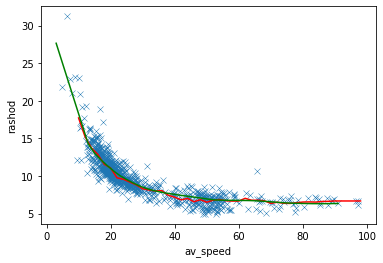

In [11]:
# предсказываем и сравниваем с результатами нейросети
res = knnr.predict(X_res)
model_data2['pred_rashod'] = pd.Series(res)
import seaborn as sns
sns.scatterplot(data=priora_detailsfree, x='av_speed', y='rashod', marker = 'x')
sns.lineplot(data=model_data2, x='vel', y='pred_rashod', color='red')
# метод ближайших соседей дает ломаную кривую, и чувствителен к выбросам

sns.lineplot(data=Priora_pred_data2.query('temperature == 10'), x='vel', y='pred_rash', color='green')

In [13]:
# сделаем множественную линейную регрессию
x_train = priora_detailsfree[['temperature', 'av_speed']]
x_train['1/v'] = np.power(x_train.av_speed, -1)
x_train['T^2'] = np.power(x_train.temperature, 2)
y_train = priora_detailsfree.rashod
x_train['BadPoint'] = x_train['temperature'].isnull()
x_train2 = x_train.dropna().drop('BadPoint', axis=1)
y_train2 = priora_detailsfree.dropna().rashod
# обучаем модель
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(x_train2, y_train2)
k0 = regr.intercept_
kT, kV, kvobr, kT_2 = regr.coef_

<ipython-input-13-837e65b50c4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['1/v'] = np.power(x_train.av_speed, -1)
<ipython-input-13-837e65b50c4d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['T^2'] = np.power(x_train.temperature, 2)
<ipython-input-13-837e65b50c4d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

<AxesSubplot:xlabel='av_speed', ylabel='rashod'>

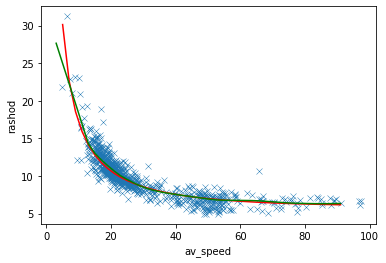

In [15]:
# создаем функцию для предсказания значений расхода от температуры и скорости
def predict_rashod(Temper, Velos):
    return k0+kT*Temper+kT_2*(Temper**2)+kV*Velos+kvobr/Velos

# строим модель предсказания расхода и сравниваем с результатом нейросети
import matplotlib.pyplot as plt
import seaborn as sns

model_data = pd.DataFrame(columns=['vel', 'pred_rashod'])
for i in range(1, 45):
    v = 3+i*2
    pred_rash = predict_rashod(10, v)
    model_data.loc[i] = [v, pred_rash]

sns.scatterplot(data=priora_detailsfree, x='av_speed', y='rashod', marker = 'x')
sns.lineplot(data=model_data, x='vel', y='pred_rashod', color='red')

sns.lineplot(data=Priora_pred_data2.query('temperature == 10'), x='vel', y='pred_rash', color='green')
# нейросеть дает гладкую зависимость, но, как кажется менее точна в области малых скоростей (где мало данных и большой разброс)

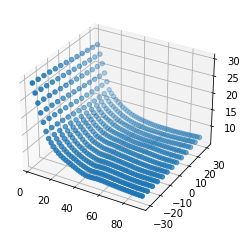

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Priora_pred_data2.vel, Priora_pred_data2.temperature, Priora_pred_data2.pred_rash)